# Churn modeling with machine learning: Medium.com employee data

In this notebook we continue the analysis of the human resources data provided by Medium on Kaggle (https://www.kaggle.com/ludobenistant/hr-analytics). It is simulated employee data of 15000 employees, and the goal is to understand something about what might cause an employee to prematurely leave the company.

The fact that we have some useful demographics about our employees, and that we know if the employee left or not means we can apply machine learning to model the data, and we can use supervised learning algorithms. As this is a classification problem (with two outcomes, will leave, or will stay) I will apply a suite of standard classification algorithms: logistic regression, random forest, SVM, and naive Bayes. One of the benefits of machine learning algorithms is you don't have to do any preliminary data exploration - the algorithm can decide for itself if a feature is relevant or not. However, from our preliminary data exploration, we found that the majority of people who leave cluster into one of three groups, depending on satisfaction level, working hours, and number of projects. This suggest that the model is strongly non-linear or conditional, and that random forest will work well. 

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [3]:
from __future__ import print_function

In [4]:
sns.set_context("talk")

## Data reading and preprocessing

The data is pretty clean. There is no missing data, and formats are all sensible. Ratings are already normalized to be between 0 and 1. We just need to convert categorical columns into dummy variables (for each category, there is a column associated with it with a value of true or false, depending on if it is that category). We're ready to start looking for interesting features in the data!

In [5]:
#data is comma-delimited csv, with headers in the first line
df = pd.read_csv('HR_comma_sep.csv')

In [6]:
#rename column sales to dept
df = df.rename(columns={'sales':'dept'})

In [7]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
dept                      object
salary                    object
dtype: object

In [8]:
#create dummy variables for columns that are categorical: dept, and salary
df = pd.get_dummies(df)
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'dept_IT', 'dept_RandD', 'dept_accounting',
       'dept_hr', 'dept_management', 'dept_marketing', 'dept_product_mng',
       'dept_sales', 'dept_support', 'dept_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

## Data exploration

We have lots of interesting information that might impact an employee's attitudes. We have direct measures of her general happiness level (satisfaction_level) and her employer's attitude about her (last_evaluation). A measure of workload can be gauged from number of projects and average monthly hours. A measure of rewards from the employer can be found in salary and number of promotions in the last 5 years. Her status in the company could be gleaned from her salary level, department, time spent at the company, and number of projects. 

In [9]:
#How many people leave?
print('Ratio of people who leave: {:.2f}'.format(df.left.mean()) )

Ratio of people who leave: 0.24


This means that if our model predicts that everyone stays and no one leaves, it will be 0.76 accurate against the data that we have. 

#### Correlation matrix

The correlation matrix of the data is a straightforward first tool to look at the relationships between features and the churn variable. To check if the correlation is significant we also calculate the p-value. Note that the categorical features and their N dummy variables have N-1 degrees of freedom, and have an internal correlation. 

<IPython.core.display.Javascript object>


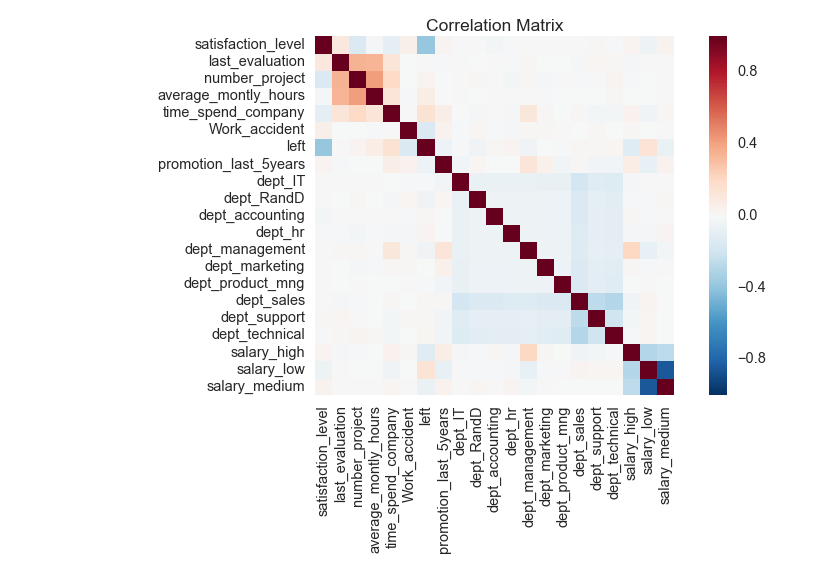

In [10]:
corrmat = df.corr()
plt.figure()
sns.heatmap(corrmat, vmax=1., square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.tight_layout();

We can see that the features that have some direct correlation with leaving is satisfaction level, along with at a lesser level time spent at the company and a low salary. Between the features, there is positive correlation among last_evaluation, number_project, and average_monthly_hours, and to a lesser degree time_spend_company and satisfaction_level. There are also correlations between being in management and a high salary, getting a promotion in the last 5 years, and the time spent in the company. There is also some correlation between categories within the same features, as highlighted above.

To make sure a correlation is significant, the p-value is also calculated. The calculation for the p-values are shown at the end of this section; All p-values are very small, so all correlations are significant.

#### Pair plots

Let's plot pairwise plots of the first five features which had a cluster of correlations. The package seaborn has some great plotting functions that make it easy to do this. As busy as this plot is, it provides almost all pairwise comparisons you might want to do all in one graph. The grid of plots below show histograms of an individual feature along the diagonal, with green indicating people who left, and blue people who stayed.

<IPython.core.display.Javascript object>


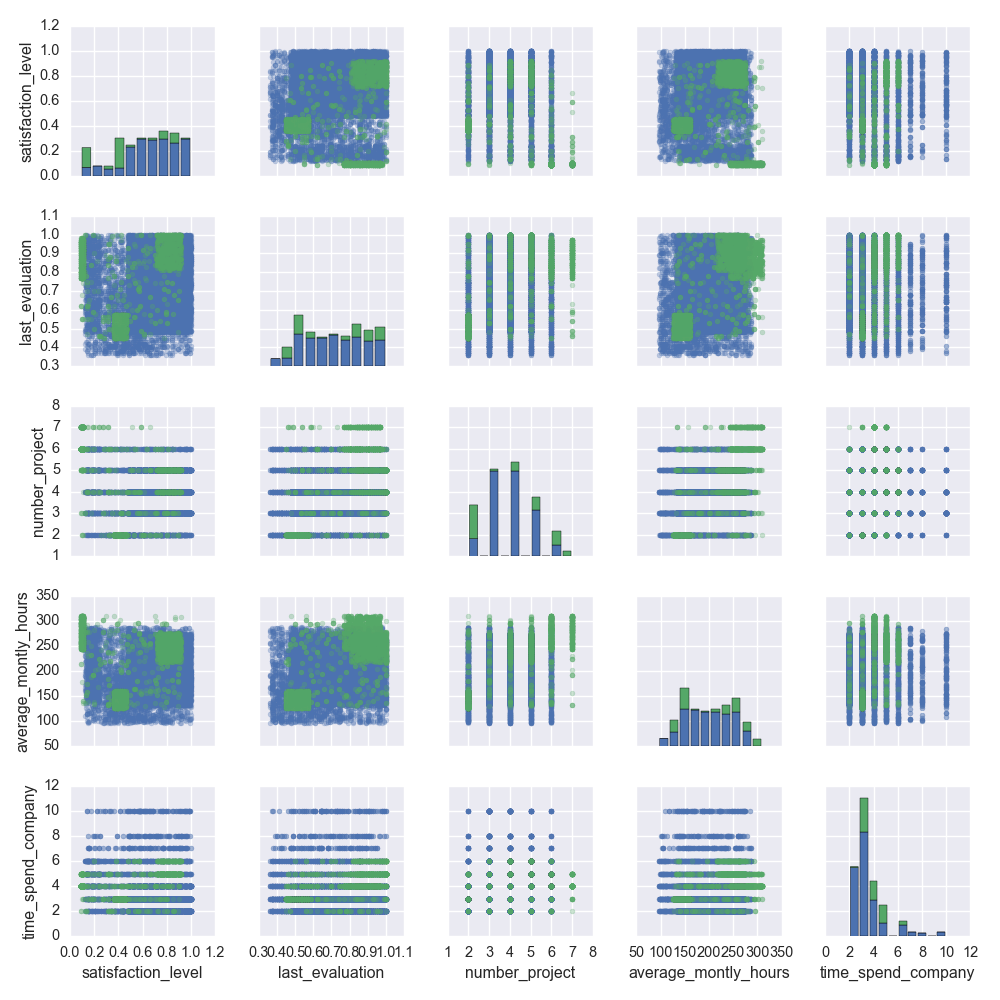

In [11]:
g = sns.PairGrid(df, hue='left', vars=df.columns[0:5])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter,alpha=0.3)

Some thoughts that come up looking at the plots are: 
* is there a bimodal distribution for leaving - seems there are two peaks in most plots for leavers - those who have high or low satisfaction, high or low evaluations, and those who work part-time or overtime.
* there are clearly three clusters of leavers when monthly hours and satisfaction level are compared: people who work part-time and have medium satisfaction levels and evaluations, people who work overtime and have high satisfaction levels and evaluations, and people who work overtime and have very low satisfaction levels but high evaluations.
* there are no leavers if the employee has stayed over 6 years. Leavers will leave within 6 years.

There seems to be an interesting story behind the satisfaction vs work hours plots. Do they partition by department, or number of projects? The answer is it does partition very neatly with number of projects, but not with other features.

<IPython.core.display.Javascript object>


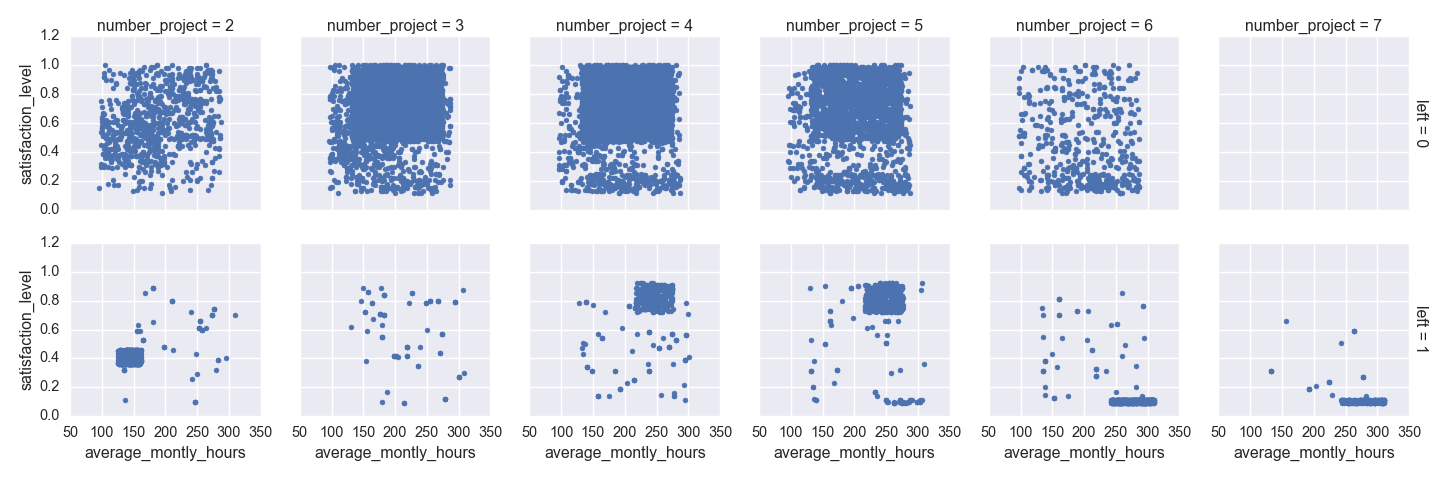

In [12]:
# satisfaction vs work hours for number of projects  
g = sns.FacetGrid(df, col="number_project", row="left", margin_titles=True)
g.map(plt.scatter, "average_montly_hours", "satisfaction_level");

Those with less than full time hours (less than 176 hours per month) were not vastly unhappy, so a possible interpretation is that people in this group desire more responsibility and a full time job, and therefore leave, or perhaps they are bored and therefore leave. Helpful knowledge might be to parse satisfaction level into different aspects like sense of responsibility, number of hours, or work topic.
Those who worked overtime and had 4-5 projects were very satisfied (rating of >0.7). A possible interpretation is that the number projects felt manageable, hence the high satisfaction level, they worked overtime because they wanted to, and they left because they simply got better offers. Those who worked overtime and had 6-7 projects and are very unsatisfied (rating of 0.1). A possible interpretation is that the number of concurrent projects was too overwhelming, leading to the forced overtime, and a desire to leave and find a more manageable situation.

Let's take a closer look at the numbers involved here. What are the counts for each of these subsets?
As you can see below, for the subset who work parttime and have two projects, the ratio is nearly 2:1 of those who leave versus stay. Contrarywise, those who have 4-5 projects mostly stay, with a ratio of 1:6 who leave versus stay, which is consistent with the idea that 4-5 projects is manageable. 
The majority of those with 6 projects leave, and all people burdened with 7 projects leave, which is consistent with the idea that 6-7 projects is overwhelming. 

In [13]:
df.groupby(['number_project','left']).size()

number_project  left
2               0        821
                1       1567
3               0       3983
                1         72
4               0       3956
                1        409
5               0       2149
                1        612
6               0        519
                1        655
7               1        256
dtype: int64

To test out the scenarios speculated on above, let's look at the what the evaluations of the people who leave are. If the leavers who are working parttime are bored, then perhaps that is reflected in lukewarm evaluations. While the distribution of evaluations span from 0.3 to 1.0, the majority of those who leave have evaluations of 0.4-0.6. If they are hoping to be turned fulltime and aren't, there might be a threshold under which people leave. This can be seen below, in that the majority of those who leave with 2 projects leave at 3 years.

Those who have 4-5 projects and leave were speculated as doing well, and working overtime because they want to. They potentially leave because they simply got better offers. Such people would be expected to get good evaluations, and this is observed. This cluster of people have satisfaction levels of greater than 0.7, and evaluations greater than 0.8.

Those who worked overtime and had 6-7 projects and were very unsatisfied also had high evaluations, of greater than 0.75. They might be overworked and unhappy and therefore motivated to leave their job, but since they are doing their job well, and they are able to get another job.

In general leavers leave within 5 years; anyone who is ambitious and not getting promoted might leave.

<IPython.core.display.Javascript object>


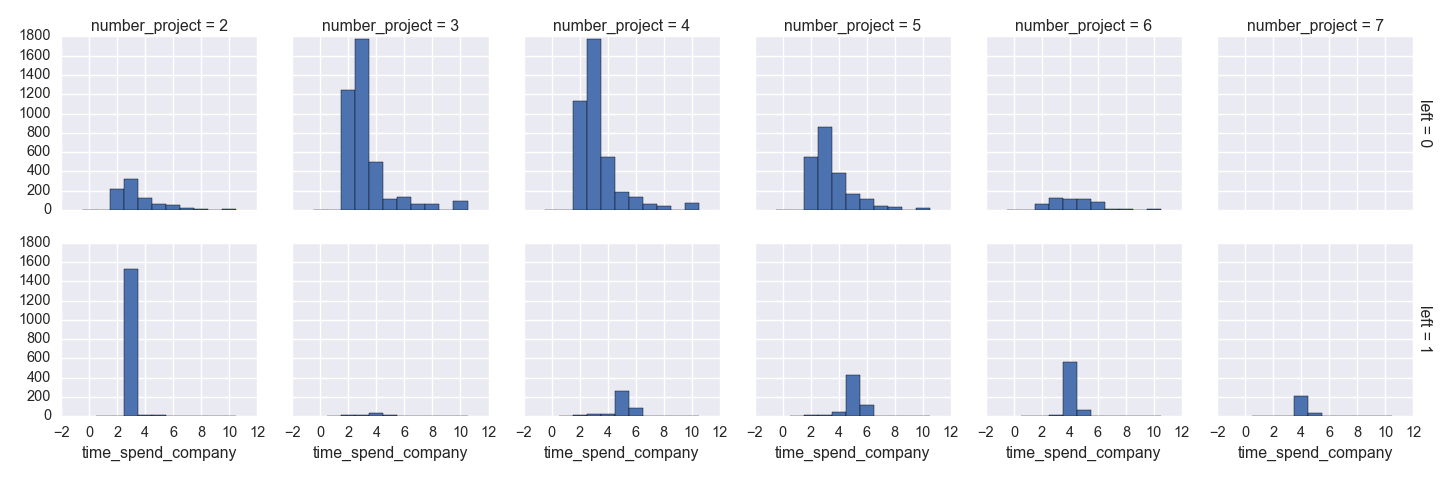

In [14]:
# satisfaction vs time at company for number of projects  
g = sns.FacetGrid(df, col="number_project", row="left", margin_titles=True)
g.map(plt.hist, "time_spend_company", bins = np.arange(-.5, 11.5, 1));

#### Promotion

In [15]:
#How many people get promotions?
df.groupby([df.promotion_last_5years,df.left]).size()

promotion_last_5years  left
0                      0       11128
                       1        3552
1                      0         300
                       1          19
dtype: int64

In [16]:
print('Ratio who got promotions in last 5 years: {:.2f}'.format(319/14999))
print('Ratio of promoted who leave: {:.2f}'.format(19/(300+19)))
print('Ratio of those not promoted who leave: {:.2f}'.format(3552/(11128+3552)))

Ratio who got promotions in last 5 years: 0.02
Ratio of promoted who leave: 0.06
Ratio of those not promoted who leave: 0.24


Only 2% of people got promotions in the last 5 years. And out of those who get promoted, only 6% leave. Otherwise, almost a quarter of people leave. So while promotion does distinguishes a population as a lower risk group, they are only 2% of the total. Promotion alone cannot tell us why the majority of those who leave do so.

For another look at the data, please take a look at the accompanying Data Story notebook, where I step through the stream of consciousness exploration of an unknown dataset. 

#### p-value calculation

In [17]:
from scipy.stats import pearsonr
#correlation and pvalues for first 5 features
coeffmat = np.zeros((5, 5))
pvalmat = np.zeros((5, 5))

for i in range(5):    
    for j in range(5):        
        corrtest = pearsonr(df[df.columns[i]], df[df.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df.columns[0:5], index=df.columns[0:5])
dfpval = pd.DataFrame(pvalmat, columns=df.columns[0:5], index=df.columns[0:5])
print('Correlation Coefficient')
print(dfcoeff)
print('\nP values')
print(dfpval)

Correlation Coefficient
                      satisfaction_level  last_evaluation  number_project  \
satisfaction_level              1.000000         0.105021       -0.142970   
last_evaluation                 0.105021         1.000000        0.349333   
number_project                 -0.142970         0.349333        1.000000   
average_montly_hours           -0.020048         0.339742        0.417211   
time_spend_company             -0.100866         0.131591        0.196786   

                      average_montly_hours  time_spend_company  
satisfaction_level               -0.020048           -0.100866  
last_evaluation                   0.339742            0.131591  
number_project                    0.417211            0.196786  
average_montly_hours              1.000000            0.127755  
time_spend_company                0.127755            1.000000  

P values
                      satisfaction_level  last_evaluation  number_project  \
satisfaction_level          0.000000

In [18]:
#correlation and pvalues for management and high salary, getting a promotion, and time spent
colnames = ['salary_high','promotion_last_5years','time_spend_company']
res = []
for colname in colnames:    
    res.append(pearsonr(df['dept_management'], df[colname]))  
coeffs,pvals = zip(*res)
dfcoeff = pd.DataFrame(np.array([coeffs]), columns=colnames, index=['dept_management'])
dfpval = pd.DataFrame(np.array([pvals]), columns=colnames, index=['dept_management'])
print('Correlation Coefficients')
print(dfcoeff)
print('\nP Values')
print(dfpval)

Correlation Coefficients
                 salary_high  promotion_last_5years  time_spend_company
dept_management     0.209077               0.128087            0.115436

P Values
                   salary_high  promotion_last_5years  time_spend_company
dept_management  8.580703e-148           6.821772e-56        1.154434e-45


In [19]:
#correlation and pvalues for leaving and satisfaction level, time spent, and low salary
colnames = ['satisfaction_level','time_spend_company','salary_low']
res = []
for colname in colnames:    
    res.append(pearsonr(df['left'], df[colname]))  
coeffs,pvals = zip(*res)
dfcoeff = pd.DataFrame(np.array([coeffs]), columns=colnames, index=['left'])
dfpval = pd.DataFrame(np.array([pvals]), columns=colnames, index=['left'])
print('Correlation Coefficients')
print(dfcoeff)
print('\nP Values')
print(dfpval)

Correlation Coefficients
      satisfaction_level  time_spend_company  salary_low
left           -0.388375            0.144822    0.134722

P Values
      satisfaction_level  time_spend_company    salary_low
left                 0.0        4.207680e-71  1.079994e-61


## Machine Learning modeling

### Cross validation

As we have labels that tell us what the real answer is, but we want to test our model as if it were encountering new data, it is common to divide the data into training and test subsets. A way to train and test, while subjecting all data to training and testing, is divide the data into K equal parts, where each part will be used as the test data in one run of the training-test cycle, with the remaining data used as training data. So the training and testing will be run K independent times. This is called a K-Fold cross validator, and the sci-kit learn package provides the indices for you. If your data has a greater percentage of a certain result value, you can ensure the ratio is consistent between folds using the sci-kit learn package StratifiedKFold.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

### Logistic regression

Logistic regression is a simple algorithm, but is a powerhouse - many problems can be modeled with this technique. How well will it work for our data?

One thing to keep in mind is if some features are highly correlated, then the coefficients to those features may not be indicative of their true weight. For categorical data (department and salary) where the value must be one of n categories, the degrees of freedom is actually n-1; if you know the value for the first n-1 categories, the value for the nth category is deterministic. Therefore we delete one of the dummy columns per feature. Use of L1 regularization can help eliminate features that have very little impact on the churn variable. 

We will use L1 regularization to do feature elimination. We will also look at the correlation between features to get a sense of how many features we expect 

The process is as follows:
* process data so all formats are numeric - create dummy variables for categorical data (boolean yes/no for each category) (done above)
* use built-in tool (GridSearchCV) for optimizing fit parameters, like C which is the inverse regularization coefficient 
* split data into training and test data, use StratifiedKFold to retain ratio of each category intact in each fold, since data is a little unbalanced (roughly a quarter is labeled true)
* for each "fold", train the model, and then test. See which features have the most impact on the target variable, for each fold.
* calculate prediction metrics, such as:
 * confusion matrix (true positives, false positives, true negatives, false negatives)
 * plot the true positives rate vs the false positives rate, aka reciever operating characteristic (ROC) curve
 * precision-recall (PR) curve (great for unbalanced datasets since it ignores true negatives)
 * the area under the curve (AUC) for the ROC and PR curves (larger values are better) 

In [21]:
from sklearn.linear_model import LogisticRegression

See how well default model fits to the data.

In [22]:
X = df.drop(['left','salary_medium','dept_IT'], axis=1).values
y = df.left.values
Xlabels = df.drop(['left','salary_medium','dept_IT'], axis=1).columns

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.792
Accuracy score of test set: 0.785


Recall that a model that predicts everyone stays has 0.76 accuracy; this model is not doing much better.

Tweak the input parameters, such as C, the inverse regularization coefficient.

In [24]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [0.001, 0.1, 1, 10, 100, 1000, 10000]
lr = LogisticRegression(penalty='l1')
clf = GridSearchCV(lr, {'C':Cs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X, y)))

{'C': 100}
Accuracy score: 0.792


We now know what value of C provides a better score, though, it's not greatly different from score of the default value of C=1, so we will just use the default. Now we apply k-fold cross validation, to test out the stability of feature importance.

In [25]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression(penalty='l1')

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [26]:
print('Accuracy scores for each fold:')
n_scor

Accuracy scores for each fold:


array([ 0.7994002 ,  0.79366667,  0.80666667,  0.79193064,  0.65721907])

<IPython.core.display.Javascript object>


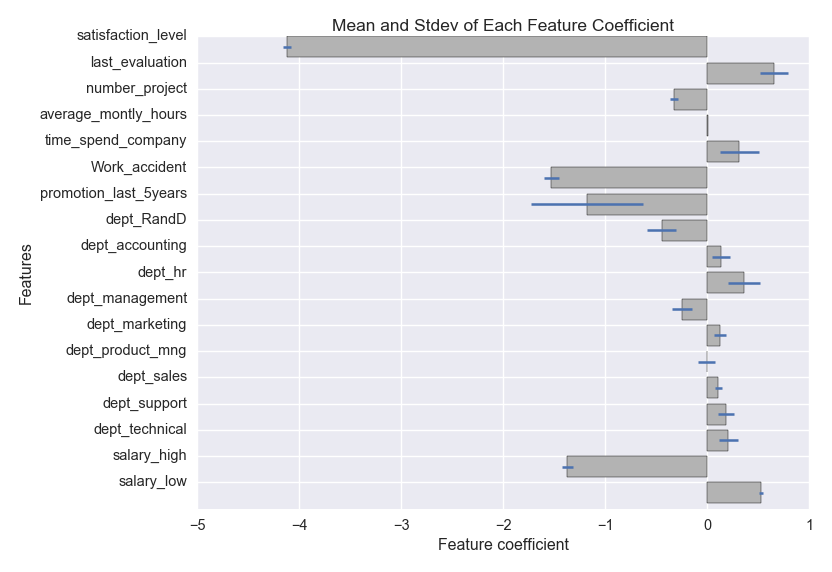

In [27]:
#plot mean and standard deviation of coefficient values for each features over the folds
xerr=np.std(f_impo,axis=0)
plt.figure()
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr,color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.title('Mean and Stdev of Each Feature Coefficient')
plt.gca().invert_yaxis()
plt.tight_layout();

In [28]:
confusion_matrix(y_true, y_pred)

array([[10235,  1193],
       [ 2260,  1311]])

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute ROC curve and area the curve
def plot_roc(y_test,y_score):
    lw = 2
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=lw,
             label='ROC')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()
    
# Plot Precision-Recall curve
def plot_pr(y_test,y_score):
    lw = 2
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    plt.figure()
    plt.plot(recall, precision, lw=lw, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC={0:0.2f}'.format(average_precision))
    #plt.legend(loc="lower left")
    plt.show()

<IPython.core.display.Javascript object>


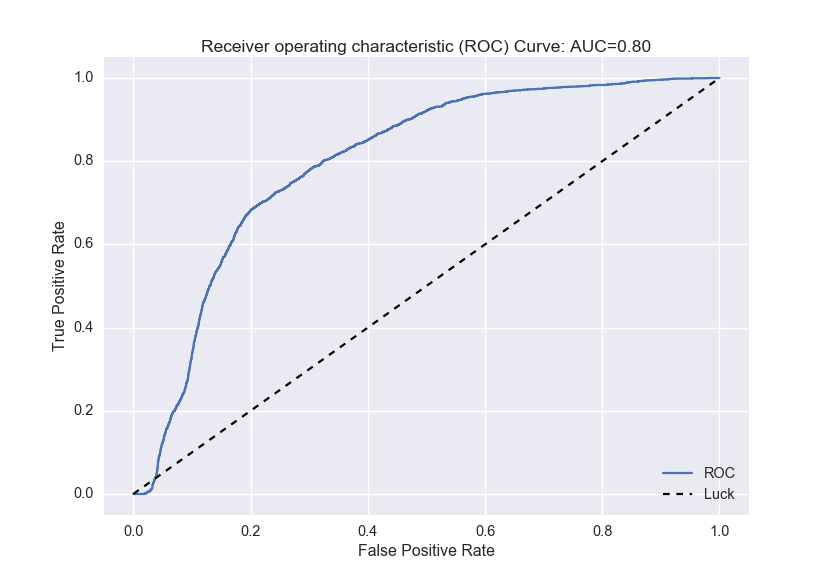

In [30]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


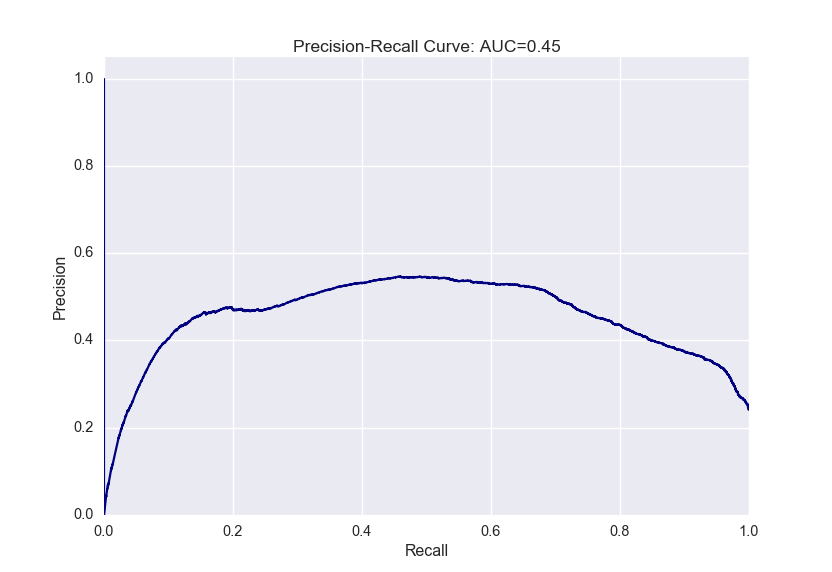

In [31]:
# Plot Precision-Recall curve
plot_pr(y_true,decfun)

### Second order, plus interaction terms

Logistic regression is a linear model - it is possible to fit non-linear behavior by adding features that are non-linear combinations of the original features. Here we do the fit with additional interaction terms.

In [32]:
from sklearn.preprocessing import PolynomialFeatures

In [33]:
poly = PolynomialFeatures(interaction_only=True)
Xinter = poly.fit_transform(X)
#poly.get_feature_names()

In [34]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,Xinter.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression()

for train, test in StratifiedKFold(nfold).split(Xinter, y):
    clf.fit(Xinter[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(Xinter[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(Xinter[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(Xinter[test],y[test])
    offset += len(test)
    n += 1

In [35]:
print('Accuracy scores for each fold:')
n_scor

Accuracy scores for each fold:


array([ 0.92769077,  0.918     ,  0.91466667,  0.92930977,  0.8396132 ])

<IPython.core.display.Javascript object>


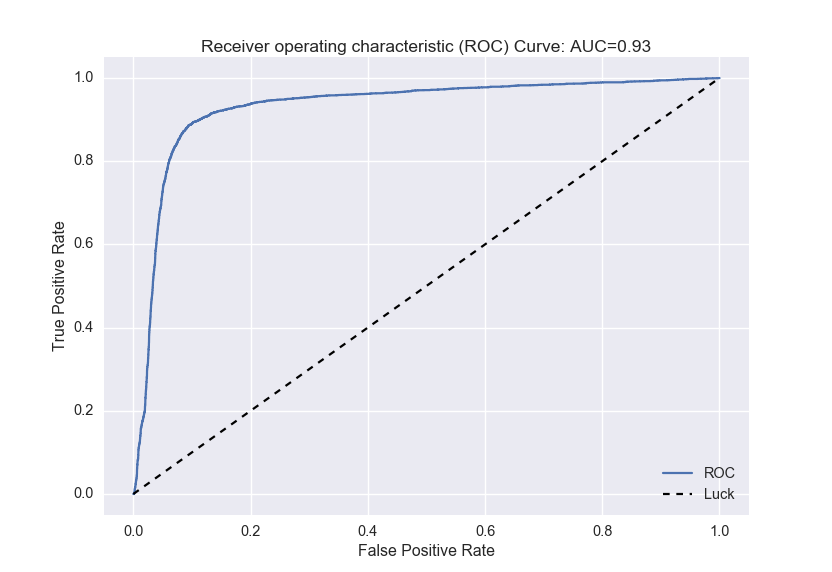

In [36]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


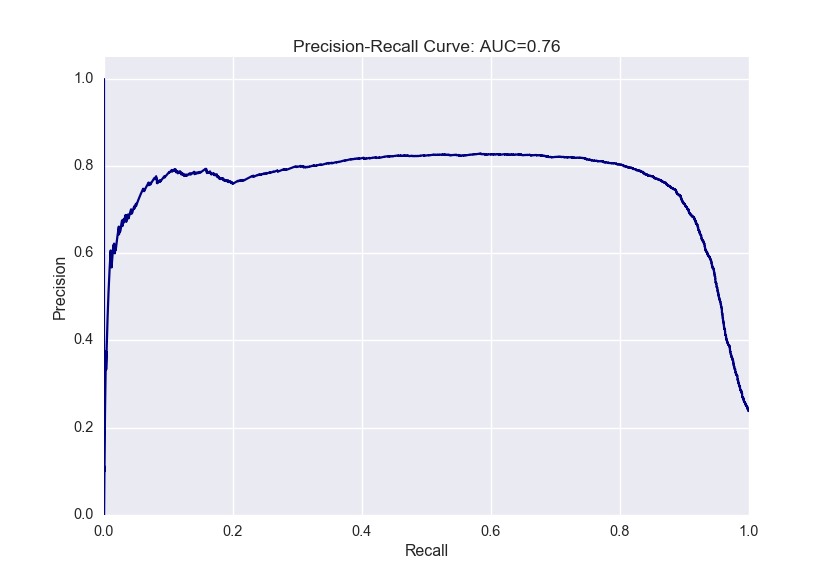

In [37]:
plot_pr(y_true,decfun)

The logistic regression predicted much better with the interaction terms. However the accuracy is only around 90%, and we would like to do better than that.

## Random Forest

Decision trees are fast, but prone to overfitting - hence the ensemble technique of random forest. While any one tree will not give us a sense of what are the most important features, which is one of the learnings desired from churn analysis - what changes need to be made to avoid churn - it can be a very good predictor.

As we have labels that tell us what the real answer is, but we want to test our model as if it were encountering new data, it is common to divide the data into training and test subsets. A way to train and test, while subjecting all data to training and testing, is divide the data into equal parts, and cycle through these parts, where each cycle uses a different subset for testing. This is called a K-Folds cross validator, and the sci-kit learn package provides the indices for you.

The process is as follows:
* process data so all formats are numeric - create dummy variables for categorical data (boolean yes/no for each category) (done above)
* split data into training and test data, use StratifiedKFold to retain ratio of each category intact in each fold, since data is a little unbalanced (roughly a quarter is labeled true)
* for each "fold", train the model, and then test
* try classifier with default values. if necessary, optimize fit parameters, like the number of estimators, criterion (gini or entropy), and minimum impurity split 
* calculate prediction metrics, such as:
 * confusion matrix (true positives, false positives, true negatives, false negatives)
 * plot the true positives rate vs the false positives rate, aka reciever operating characteristic (ROC) curve
 * precision-recall (PR) curve (great for unbalanced datasets since it ignores true negatives)
 * the area under the curve (AUC) for the ROC and PR curves (larger values are better) 


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

In [39]:
X = df.drop('left', axis=1).values
y = df.left.values
Xlabels = df.drop(['left'], axis=1).columns

First, a quick check of how well the default model works on the data on a simple split of training and test data.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [41]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.999
Accuracy score of test set: 0.990


The fit is already very good, for the training and test set. Can the fit be tweaked even better? Use GridSearchCV to find best parameters.

In [42]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
nEs = [10, 100, 500]
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, {'n_estimators':nEs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'n_estimators': 100}
Accuracy score: 1.000


In [43]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.000
Accuracy score of test set: 0.992


In [44]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.000
Accuracy score of test set: 0.993


With GridSearchCV, the greater number of estimators has better accuracy, but takes much longer to run. Now, with KFold, to do cross validation, and look at stability of feature importance.

In [45]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0

clf = RandomForestClassifier(n_estimators=500)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.predict_proba(X[test])[:,1]
    f_impo[n,:] = clf.feature_importances_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [46]:
print('Accuracy scores for each fold:')
n_scor

Accuracy scores for each fold:


array([ 0.99833389,  0.979     ,  0.983     ,  0.99866622,  0.99599867])

Now that we've run the 5-fold cross validation, let's take a look at the feature importance, and performance metrics. 

<IPython.core.display.Javascript object>


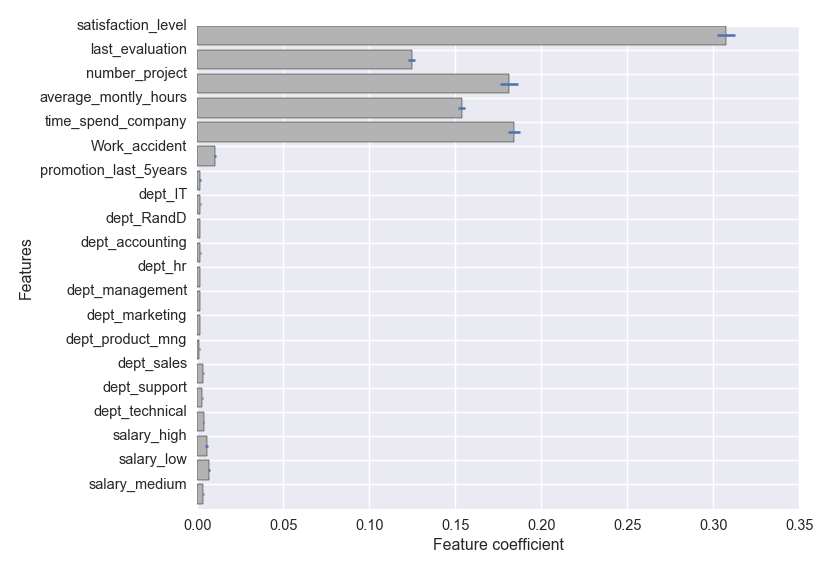

In [47]:
xerr=np.std(f_impo,axis=0)
plt.figure()
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr, color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout();

The features that are most important are satisfaction level, last evaluation, number of projects, average monthly hours, and time spent at the company. You can see below that the accuracy is very good using random forest on this data. The areas under the curve for both the ROC and Precision-recall curves are 0.99, indicating that the model is very good

In [48]:
confusion_matrix(y_true, y_pred)

array([[11389,    39],
       [   96,  3475]])

<IPython.core.display.Javascript object>


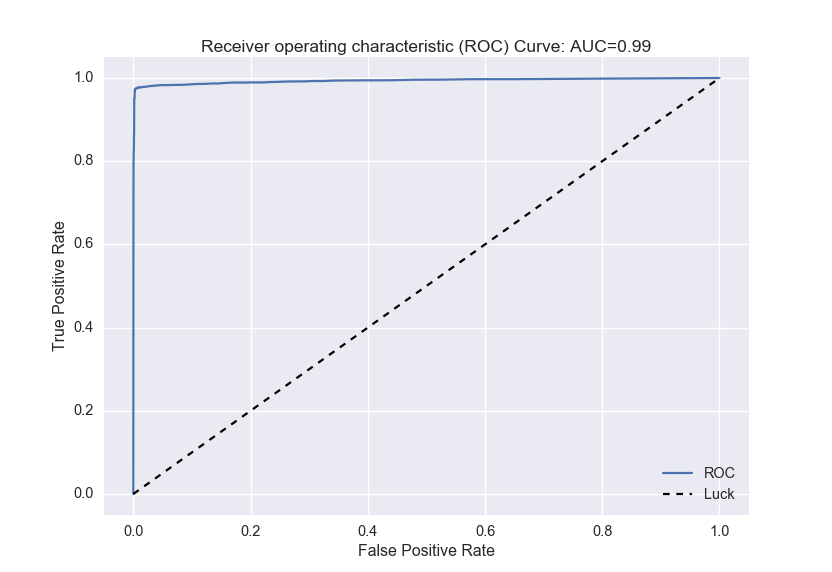

In [49]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


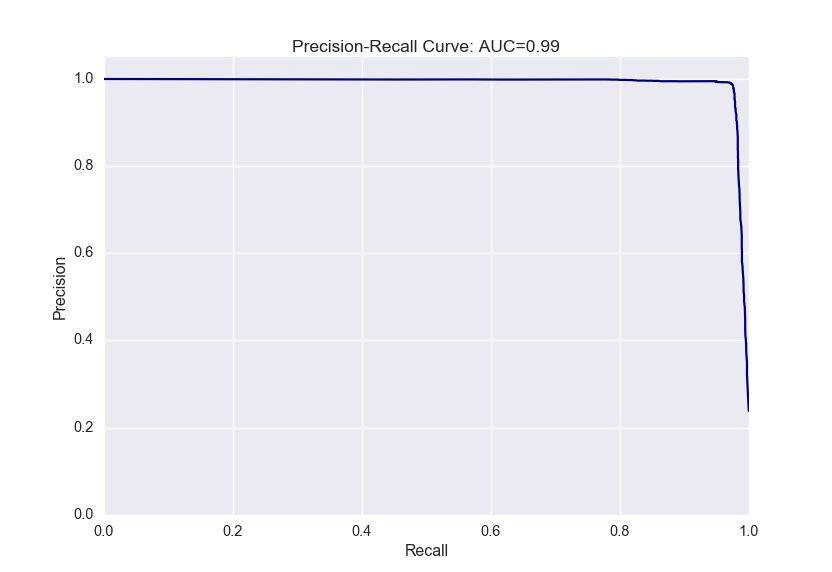

In [50]:
# Plot Precision-Recall curve
plot_pr(y_true,decfun)

Random forest, even the default model, trains and predicts very well on our data. It achieves 99% accuracy in the test data, as well as the training data. Random forest also conveniently provides a metric for feature importance. Over the five folds in the cross validation, the feature importance stayed very stable, and the five features that are very strong in influence are satisfaction level, last evaluation, number of projects, average monthly hours, and time spent at the company.

## Support Vector Machines

Support Vector Machines is great for non-linear models, since you can have arbitrarily more dimensions with little additional computational cost, because of the "kernel trick". We will try a series of kernels. It is more difficult to glean learnings from SVM - the coeffients especially for higher order models don't necessarily indicate feature importance.

It is recommended that the data be normalized; SVM is not scale invariant. The SVM algorithm in sci-kit learn takes in both [-1,1] or [0,1]. The columns that will be normalized are number of projects, average monthly hours, time spent in company; all other columns have values between 0 and 1.

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [11]:
X = df.drop('left', axis=1).values
y = df.left.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

### Linear kernel

In [54]:
#see how well the default model works
clf = LinearSVC()
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.773
Accuracy score of test set: 0.783


In [55]:
clf = LinearSVC(penalty='l1',dual=False)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.773
Accuracy score of test set: 0.783


In [56]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [0.001, 0.1, 1, 10, 100, 1000, 10000]
svc = LinearSVC(penalty='l1',dual=False)
clf = GridSearchCV(svc, {'C':Cs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'C': 0.001}
Accuracy score: 0.795


The linear kernel seems to do as well as the logistic regression, which not great. Let's look at other kernels.

### RBF kernel

In [13]:
#see how well the default model works
clf = SVC()
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.864
Accuracy score of test set: 0.864


In [18]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [10, 100, 1000, 10000, 100000]
gammas = [0.001, 0.01, 0.1, 0.5, 1]
svc = SVC()
clf = GridSearchCV(svc, {'C':Cs,'gamma':gammas})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'C': 10000, 'gamma': 1}
Accuracy score: 0.997


In [ ]:
clf = SVC(gamma=1,C=10000)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.997
Accuracy score of test set: 0.965


In [13]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
y_score = np.zeros((len(y),2))
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = SVC(gamma=1,C=10000,probability=True)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    y_score[offset:(offset+len(test))] = clf.predict_proba(X[test])
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

<IPython.core.display.Javascript object>


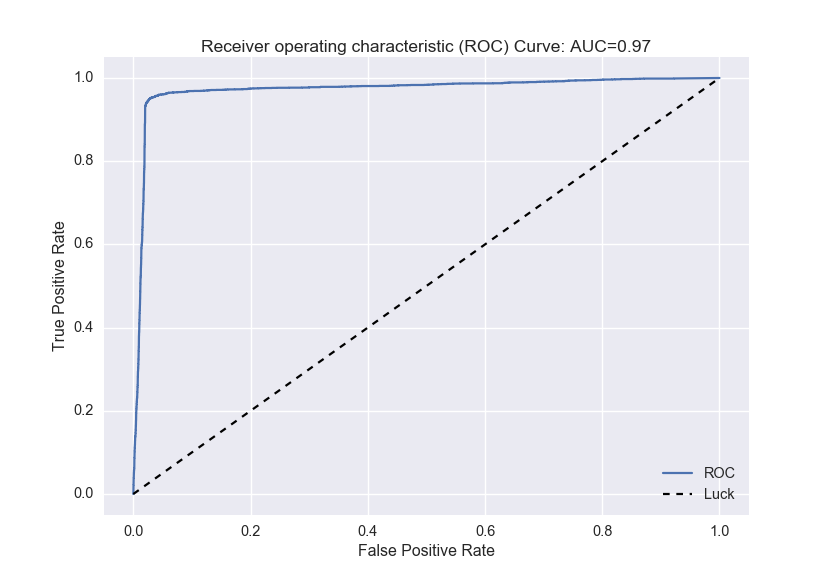

In [16]:
plot_roc(y_true,y_score[:,1])

<IPython.core.display.Javascript object>


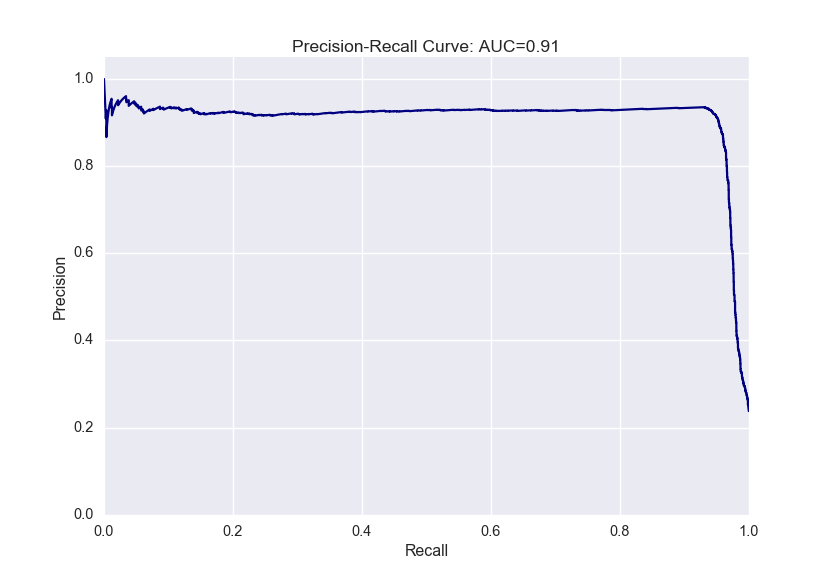

In [17]:
plot_pr(y_true,y_score[:,1])

SVM with the RBF kernel is able to achieve 96% accuracy, and the ROC and precision-recall curves are both over 90%; the linear kernel achieved 80%. However, we don't just wish to predict who will leave, but want to be able to make recommendations about what the company can do to reduce churn - in this case Random Forest is still the best option with regards to prediction accuracy, and being able to indicate feature importance. Additionally, the SVM calculation was much more intensive than the random forest fit.

## Discussion

Random forest was the best model for our data, for prediction and for suggesting which features had the most impact. The data, when explored in pair plots, was highly non-linear, and collected in quilt-like patterns, which indicate conditional relationships, and that random forest is a good choice. The accuracy of the model even on test data approached 99%, with beautiful ROC and precision-recall curves. The features that random forest highlighted as the most important were satisfaction level, last evaluation, number of projects, monthly hours, and time spent at the company.

Logistic regression and SVM was also applied to the data. As might be expected, linear models like logistic regression and SVM with a linear kernel did not predict well, with accuracy little better than predicting that everyone stays. When interaction terms were added to the logistic regression, prediction vastly improved, but still only to 90% accuracy, which is still far below the 99% accuracy of random forest. SVM with the rbf kernel also did much better than the linear kernel, with an accuracy of 96% on test data, but again, random forest outperformed SVM, and also provides feature importance.